In [25]:
import json
import lzma
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import ast
import random
import numpy as np

In [26]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")

In [27]:
def get_url(item):
    return "https://www.opac-fabritius.be" + item["low_res_filename"]

def get_folders_from_path(path):
    return "./" + "/".join(path.split("/")[1:-1])

# Test
print(get_folders_from_path("/art-foto/mod/Internet/deGroux-12315dig-L.jpg"))
print(get_folders_from_path("/art-foto/mod/Internet/"))

./art-foto/mod/Internet
./art-foto/mod/Internet


In [28]:
def fixPath(path):
    # From: ./../../.././private_data/local_images/art-foto/mod/Internet/Wouters-11620dig_01-L.jpg
    # To: ./../../../private_data/local_images/art-foto/mod/Internet/Wouters-11620dig_01-L.jpg
    return path.replace("./../../.././private_data", "./../../../private_data")

In [29]:
filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
filtered_data_downloaded

recordLanguage  recordID DatabaseId  \
0               fre     10002  Fabritius   
1               fre     10004  Fabritius   
2               fre     10005  Fabritius   
3               fre     10016  Fabritius   
4               fre      1003  Fabritius   
...             ...       ...        ...   
3007            fre      9959  Fabritius   
3008            fre      9960  Fabritius   
3009            fre      9962  Fabritius   
3010            fre       999  Fabritius   
3011            fre      9996  Fabritius   

                                            LinkToVubis  \
0     http://193.190.214.119/fabritiusweb/LinkToVubi...   
1     http://193.190.214.119/fabritiusweb/LinkToVubi...   
2     http://193.190.214.119/fabritiusweb/LinkToVubi...   
3     http://193.190.214.119/fabritiusweb/LinkToVubi...   
4     http://193.190.214.119/fabritiusweb/LinkToVubi...   
...                                                 ...   
3007  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3008  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3009  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3010  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3011  http://193.190.214.119/fabritiusweb/LinkToVubi...   

     objectWork.creatorDescription          objectWork.termClassification  \
0                   Henry de Groux           peinture (Dept. Art Moderne)   
1                     Pierre Oyens           peinture (Dept. Art Moderne)   
2                 Ferdinand Roybet           peinture (Dept. Art Moderne)   
3                   Henry de Groux           peinture (Dept. Art Moderne)   
4                   Alfred Stevens           peinture (Dept. Art Moderne)   
...                            ...                                    ...   
3007        Eugène Laermans, baron  oeuvre sur papier (Dept. Art Moderne)   
3008        Eugène Laermans, baron  oeuvre sur papier (Dept. Art Moderne)   
3009               Fernand Khnopff  oeuvre sur papier (Dept. Art Moderne)   
3010              Constant Montald           peinture (Dept. Art Moderne)   
3011              Jacques Jordaens   oeuvre sur papier (Dept. Art Ancien)   

     objectWork.workID         objectWork.titleText objectWork.objectWorkType  \
0                12315    Portrait de Paul Verlaine       ['tableau (toile)']   
1                 3230                Les collègues       ['tableau (toile)']   
2                 6831            Portrait de femme     ['tableau (panneau)']   
3                12502          Christ aux outrages       ['tableau (toile)']   
4                10714                Dame au chien     ['tableau (panneau)']   
...                ...                          ...                       ...   
3007             12312            Femme, vue de dos                ['dessin']   
3008             12311                 Sur le champ                ['dessin']   
3009             12264               Une aile bleue          ['photographie']   
3010             10613                  La baignade              ['détrempe']   
3011       4060 / 1955  Achéloos vaincu par Hercule             ['aquarelle']   

     objectWork.measurementsDescription  ... objectWorkType_is_esquisse  \
0                          [46.0, 38.0]  ...                      False   
1                        [202.0, 177.0]  ...                      False   
2                          [81.0, 54.0]  ...                      False   
3                        [173.0, 145.0]  ...                      False   
4                          [26.9, 20.9]  ...                      False   
...                                 ...  ...                        ...   
3007                                NaN  ...                      False   
3008                                NaN  ...                      False   
3009                                NaN  ...                      False   
3010                     [525.0, 593.0]  ...                      False   
3011                                NaN  ...

In [30]:
def describe_as_table(uniques, owt_count):
    table = pd.DataFrame(columns=["objectWorkType", "Number of appearances", "Percentage of appearances"])
    
    for i in range(len(uniques)):
        objectWorkType = uniques[i]
        number_of_records = owt_count[objectWorkType]
        percentage = round(number_of_records / len(filtered_data_downloaded) * 100, 2)
        table.loc[i] = [objectWorkType, number_of_records, f"{percentage}%"]

    table = table.sort_values(by="Number of appearances", ascending=False)
    table.reset_index(drop=True, inplace=True)
    return table

In [31]:
# Unique objectWork.objectWorkType
# Unique objectWork.objectWorkType
objectWorkType_as_list = {}
objectWorkType_to_count = {}
objectWorkType_to_recordID = {}
uniques_objectWorkType = set()

for index, row in filtered_data_downloaded.iterrows():
    L = ast.literal_eval(row["objectWork.objectWorkType"])
    recordID = row["recordID"]
    objectWorkType_as_list[recordID] = L
    uniques_objectWorkType.update(L)

    for objectWorkType in L:
        if objectWorkType_to_recordID.get(objectWorkType) is None:
            objectWorkType_to_recordID[objectWorkType] = [recordID]
        else:
            objectWorkType_to_recordID[objectWorkType].append(recordID)

    for objectWorkType in L:
        if objectWorkType_to_count.get(objectWorkType) is None:
            objectWorkType_to_count[objectWorkType] = 1
        else:
            objectWorkType_to_count[objectWorkType] += 1

uniques_objectWorkType = list(uniques_objectWorkType) # convert to list to be able to access by index
uniques_objectWorkType = sorted(uniques_objectWorkType)
print(f"There are {len(uniques_objectWorkType)} unique objectWorkType")
raw_objectWorkType_pd = describe_as_table(uniques_objectWorkType, objectWorkType_to_count)
raw_objectWorkType_pd.to_csv(FOLDER_TABLE + "raw_objectWorkType_pd.csv", index=False)
raw_objectWorkType_pd

There are 34 unique objectWorkType


objectWorkType  Number of appearances Percentage of appearances
0          tableau (toile)                   1243                    41.27%
1                   dessin                    748                    24.83%
2        tableau (panneau)                    522                    17.33%
3                 esquisse                    177                     5.88%
4                aquarelle                    158                     5.25%
5                   pastel                     46                     1.53%
6                    étude                     38                     1.26%
7         huile sur papier                     27                      0.9%
8                  gouache                     25                     0.83%
9     dessin aux 2 crayons                     19                     0.63%
10               triptyque                     19                     0.63%
11                sanguine                     18                      0.6%
12                 croquis                     14                     0.46%
13                 estampe                     14                     0.46%
14                  projet                     13                     0.43%
15   triptyque (partie de)                     11                     0.37%
16       carnet de dessins                     10                     0.33%
17                  groupe                      8                     0.27%
18    dessin aux 3 crayons                      5                     0.17%
19                détrempe                      5                     0.17%
20                   tondo                      5                     0.17%
21               statuette                      4                     0.13%
22  polyptyque (partie de)                      4                     0.13%
23             haut-relief                      4                     0.13%
24                figurine                      4                     0.13%
25                fragment                      4                     0.13%
26     retable (partie de)                      4                     0.13%
27            photographie                      3                      0.1%
28        étude académique                      2                     0.07%
29                 affiche                      1                     0.03%
30                   album                      1                     0.03%
31               miniature                      1                     0.03%
32                 ébauche                      1                     0.03%
33                    tête                      1                     0.03%

In the table \cite{TODO} above, we notice two important observations. First, the class are not equally balanced at all, for example $1243$ records contain the tag \textit{"tableau (toile)"} ($41.27\%$ of the records) while only a single record contains the tag \textit{"tête"}. Secondly, there are quite general tags like \textit{"dessin"} and subcategories of them like \textit{"dessin aux 2 crayons"}. We would therefore expect that any record having a subcategory tag would also contain the general tag. 
\newline \newline

As we want to create two sets having about $300$ images each representing the different types of images in the dataset, we will analyze the tags and process them accordingly.

In [32]:
# Convert types to one-hot encoding
d = len(uniques_objectWorkType)
N = len(filtered_data_downloaded)
one_hot_encoding = np.zeros((N, d))
for i, row in filtered_data_downloaded.iterrows():
    L = objectWorkType_as_list[row["recordID"]]
    for l in L:
        j = list(uniques_objectWorkType).index(l)
        one_hot_encoding[i, j] = 1

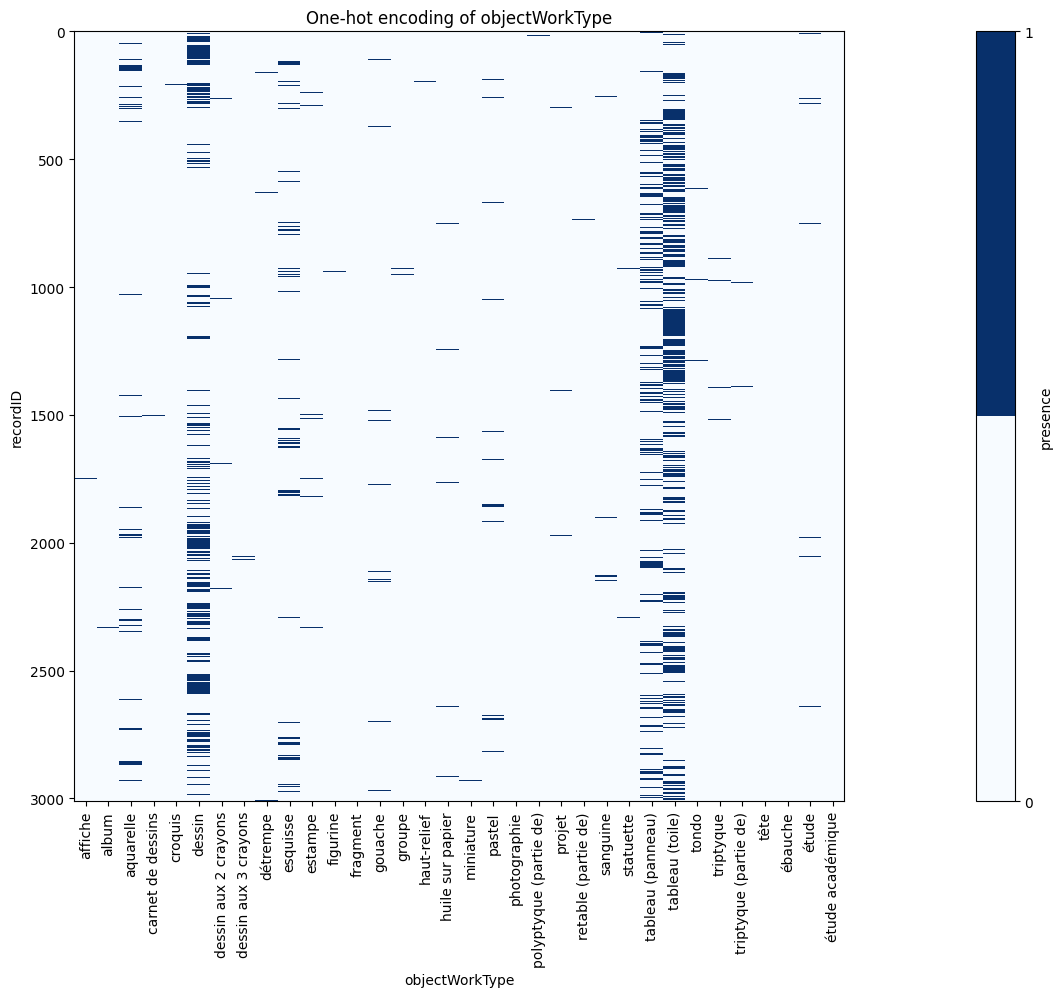

In [33]:
# Plot the one-hot encoding matrix
plt.figure(figsize=(34, 10))
mat = plt.imshow(one_hot_encoding, aspect=str(d/N), interpolation='none', vmin=0, vmax=1, cmap=plt.get_cmap('Blues', 2))
plt.xlabel("objectWorkType")
plt.xticks(range(d), uniques_objectWorkType, rotation=90)
plt.ylabel("recordID")
plt.title("One-hot encoding of objectWorkType")
# Add a binary colorbar
plt.colorbar(mat, ticks=[0,1], label="presence")
plt.clim(0, 1)
plt.show()

The figure \cite{TODO} above represents the one-hot-encoding of the records with the raw tags. Once again, we can clearly see that some tags are more popular than others.

In [34]:
def getIndexesFromRecordIDs(recordIDs):
    return [filtered_data_downloaded[filtered_data_downloaded["recordID"] == recordID].index[0] for recordID in recordIDs]

In [35]:
categories = {
    "Tableau": [
        "aquarelle",
        "détrempe",
        "gouache",
        "huile sur papier",
        "polyptyque (partie de)",
        "retable (partie de)",
        "tableau (panneau)",
        "tableau (toile)"
    ],
    "Dessin": [
        "dessin aux 2 crayons",
        "dessin aux 3 crayons",
        "croquis",
        "esquisse",
        "pastel",
        "étude",
        "étude académique",
        "carnet de dessins",
        "sanguine",
        "ébauche",
        "étude",
        "étude académique",
        "dessin",
    ],
    "Sculpture": [
        "figurine",
        "haut-relief",
        "statuette"
    ]
}

if False:
    # Generate "Autres"
    others = []
    for objectWorkType in uniques_objectWorkType:
        isAlreadyInCategory = False
        for category in categories:
            if objectWorkType in categories[category]:
                isAlreadyInCategory = True
                break

        if not isAlreadyInCategory:
            others.append(objectWorkType)
    categories["Autres"] = others

for category in categories:
    print(f"\paragraph{{Category: {category}}}")
    print("\\begin{itemize}")
    for objectWorkType in categories[category]:
        print(f"    \item {objectWorkType}")
    print("\end{itemize}")

\paragraph{Category: Tableau}
\begin{itemize}
    \item aquarelle
    \item détrempe
    \item gouache
    \item huile sur papier
    \item polyptyque (partie de)
    \item retable (partie de)
    \item tableau (panneau)
    \item tableau (toile)
\end{itemize}
\paragraph{Category: Dessin}
\begin{itemize}
    \item dessin aux 2 crayons
    \item dessin aux 3 crayons
    \item croquis
    \item esquisse
    \item pastel
    \item étude
    \item étude académique
    \item carnet de dessins
    \item sanguine
    \item ébauche
    \item étude
    \item étude académique
    \item dessin
\end{itemize}
\paragraph{Category: Sculpture}
\begin{itemize}
    \item figurine
    \item haut-relief
    \item statuette
\end{itemize}


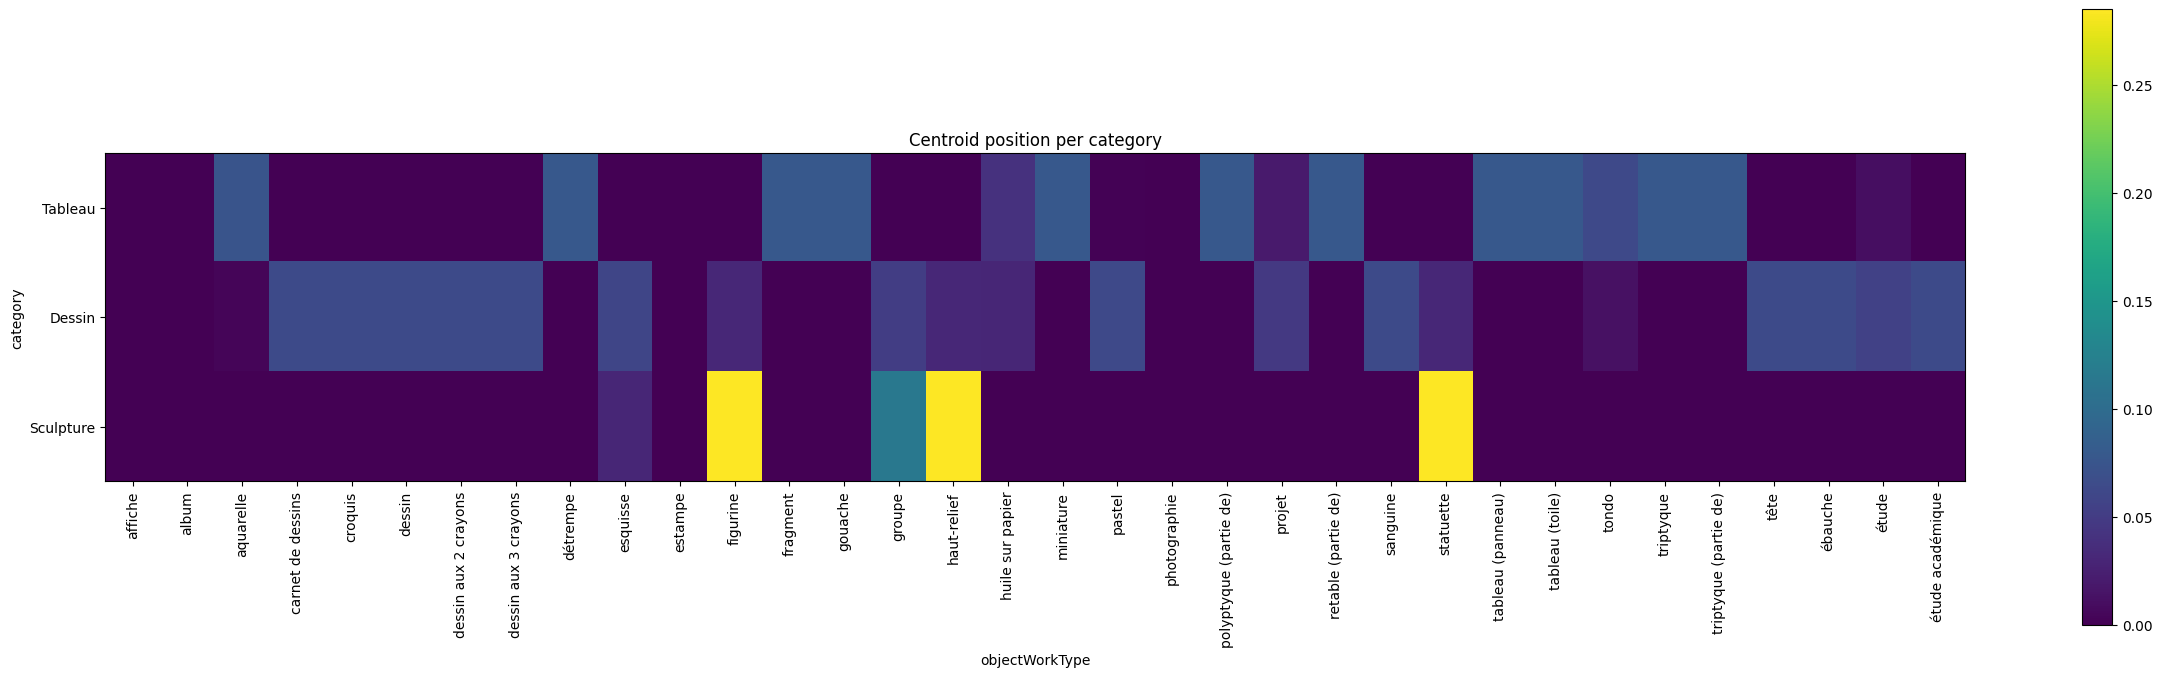

In [36]:
mean_vector_per_category = np.zeros((len(categories), d))

local_appearances_per_subcategory = np.zeros((len(categories), len(uniques_objectWorkType)))


for i, category in enumerate(categories):

    for objectWorkType in categories[category]:
        indexes = getIndexesFromRecordIDs(objectWorkType_to_recordID[objectWorkType])
        
        local_appearances_per_subcategory[i] += np.sum(one_hot_encoding[indexes], axis=0)

global_appearances_per_subcategory = np.sum(local_appearances_per_subcategory, axis=0)
global_appearances_per_subcategory += 1e-9 # Avoid division by zero

# Divide each row of local_appearances_per_subcategory by the number of objectWorkType in the category
for i in range(len(categories)):
    local_appearances_per_subcategory[i] = local_appearances_per_subcategory[i] / global_appearances_per_subcategory

# Normalize each local_appearances_per_subcategory row
for i in range(len(categories)):
    local_appearances_per_subcategory[i] = local_appearances_per_subcategory[i] / np.sum(local_appearances_per_subcategory[i])

# Plot local_appearances_per_subcategory
plt.figure(figsize=(30, 8))
mat = plt.imshow(local_appearances_per_subcategory, aspect=2, interpolation='none')
plt.xlabel("objectWorkType")
plt.xticks(range(d), uniques_objectWorkType, rotation=90)
plt.ylabel("category")
plt.yticks(range(len(categories)), categories.keys(), rotation=0)
plt.title("Centroid position per category")
plt.colorbar()
plt.savefig(FOLDER_FIGURES + "centroid_per_category.pdf")
plt.show()

In [37]:
# Use local_appearances_per_subcategory as "cluster centers" to assign each record to a category
record_to_category_table = pd.DataFrame(columns=["recordID", "category"])
for i, row in filtered_data_downloaded.iterrows():
    recordID = row["recordID"]
    indexes = getIndexesFromRecordIDs([recordID])
    distances = np.linalg.norm(one_hot_encoding[indexes] - local_appearances_per_subcategory, axis=1)
    category = list(categories.keys())[np.argmin(distances)]
    record_to_category_table.loc[i] = [recordID, category]

# Compute the count of each category
category_to_count = {}
for category in categories:
    category_to_count[category] = len(record_to_category_table[record_to_category_table["category"] == category])

# Show as a table
category_to_count_table = pd.DataFrame(columns=["Category", "Number of assigned record", "Proportion of assigned record"])
for i, category in enumerate(categories):
    count = category_to_count[category]
    percentage = round(count / len(filtered_data_downloaded) * 100, 3)
    category_to_count_table.loc[i] = [category, count, f"{percentage}%"]

category_to_count_table = category_to_count_table.sort_values(by="Number of assigned record", ascending=False)
category_to_count_table.reset_index(drop=True, inplace=True)
category_to_count_table.to_csv(FOLDER_TABLE + "category_to_count_table.csv", index=False)
category_to_count_table

Category  Number of assigned record Proportion of assigned record
0    Tableau                       1983                       65.837%
1     Dessin                       1017                       33.765%
2  Sculpture                         12                        0.398%

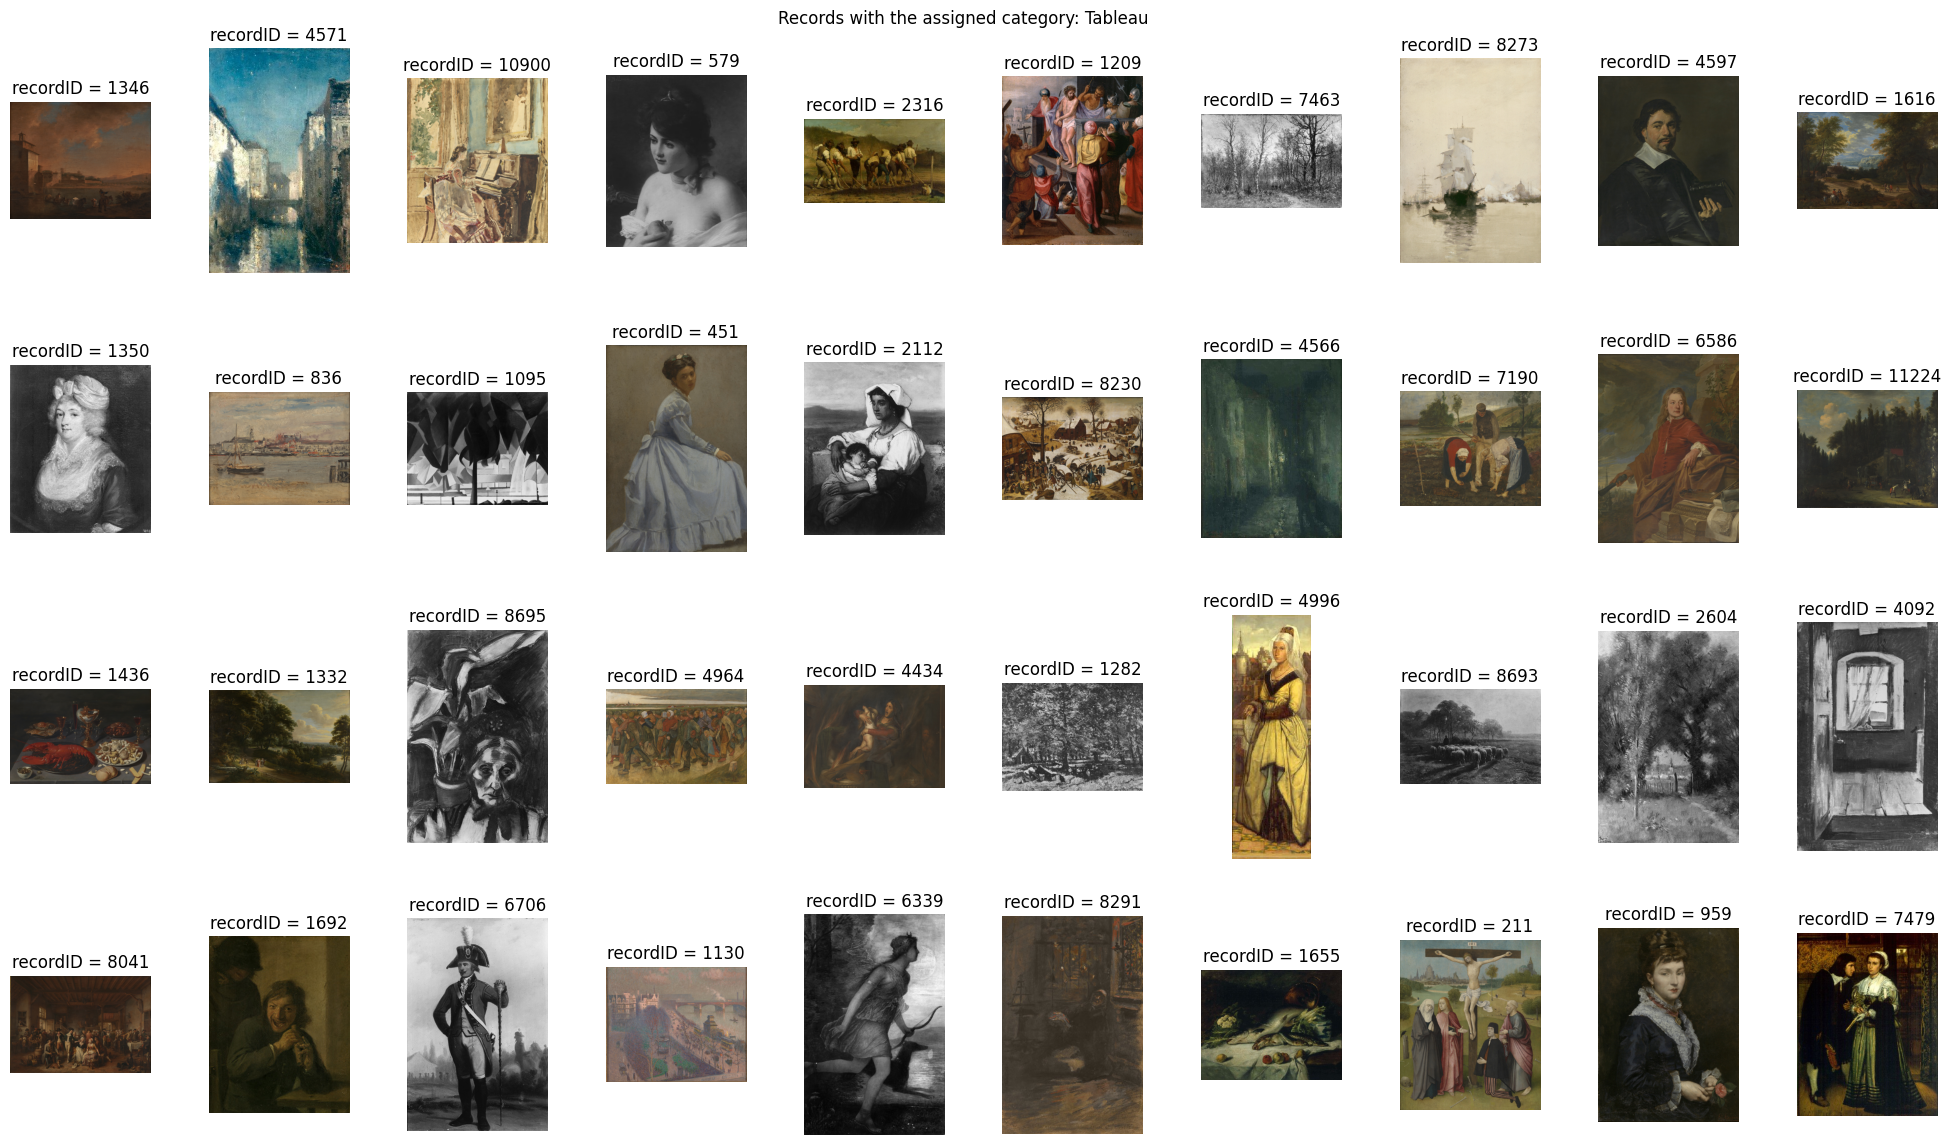

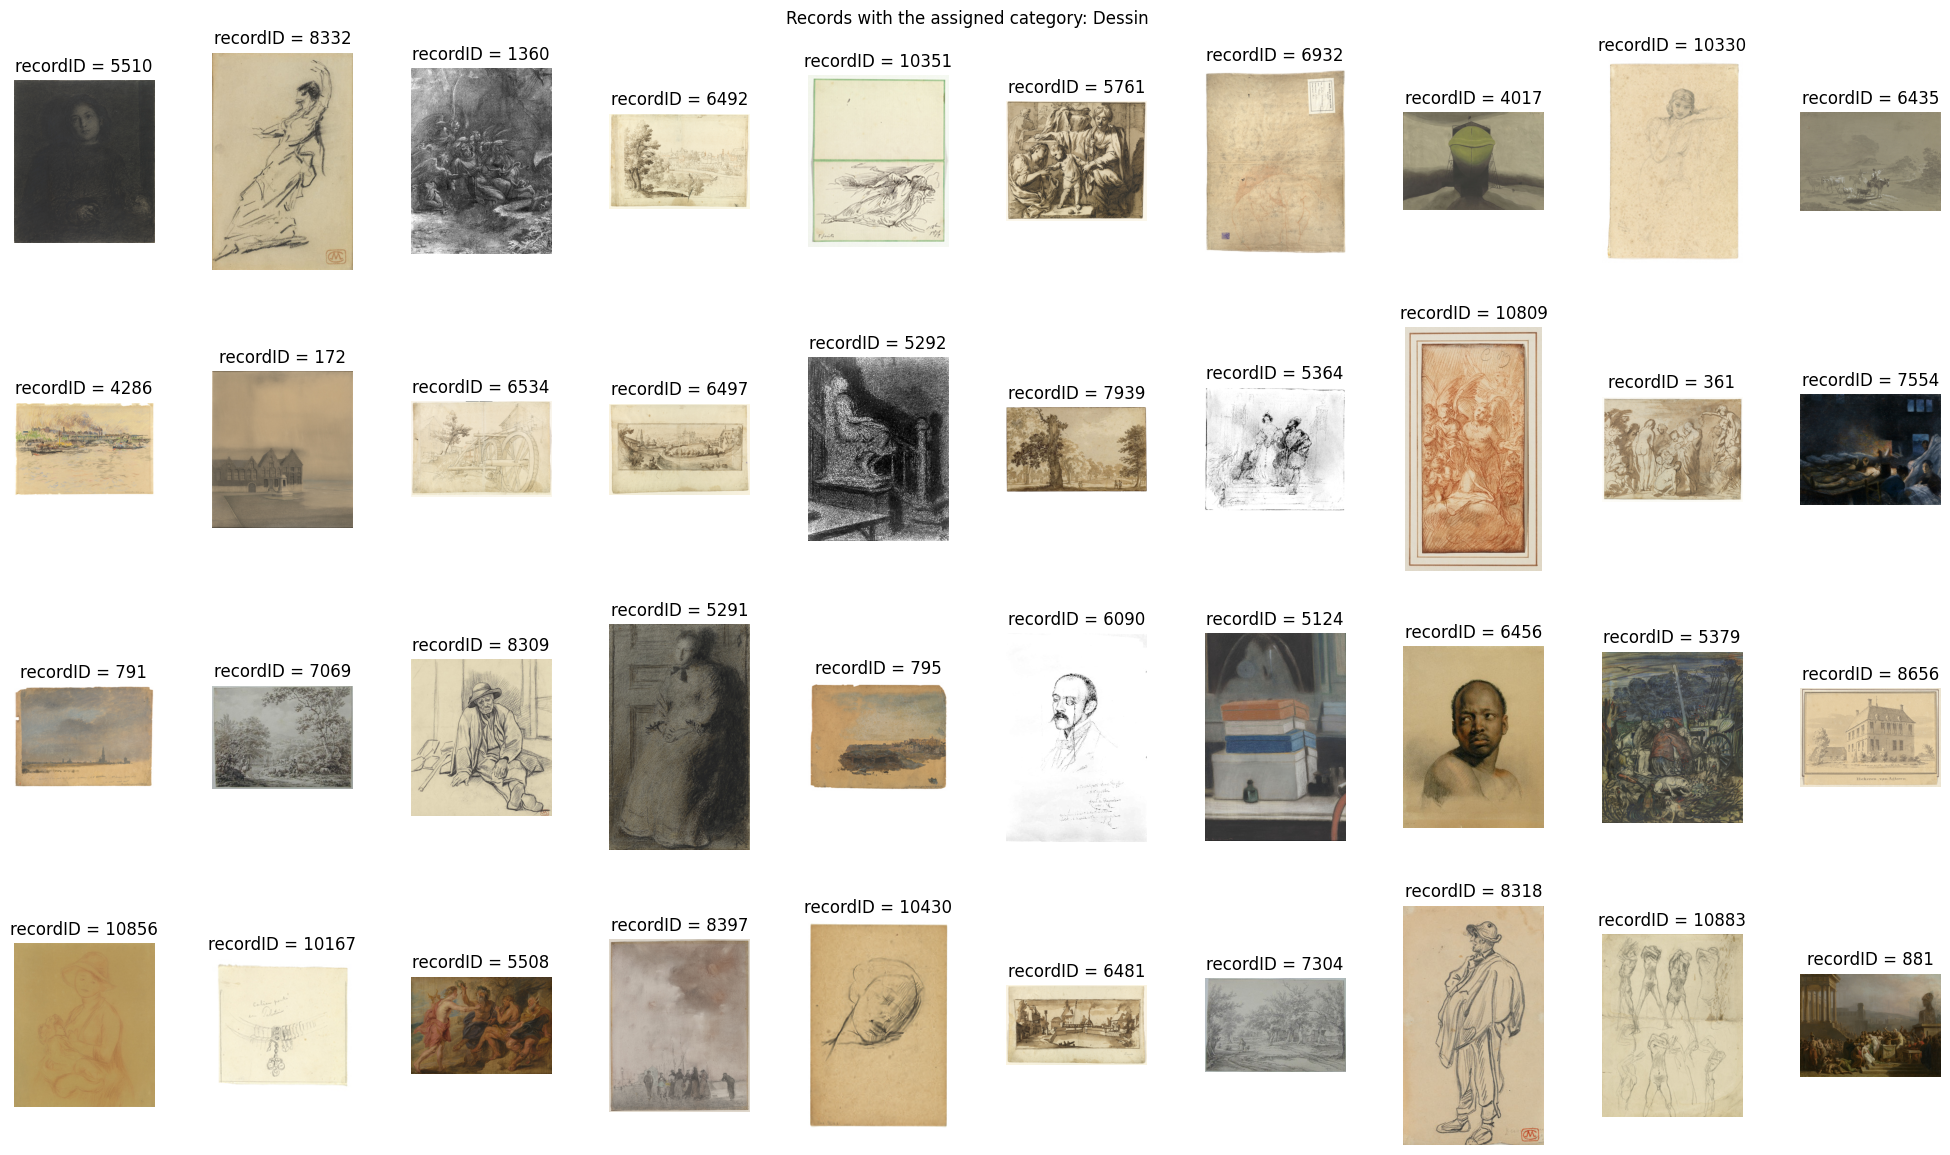

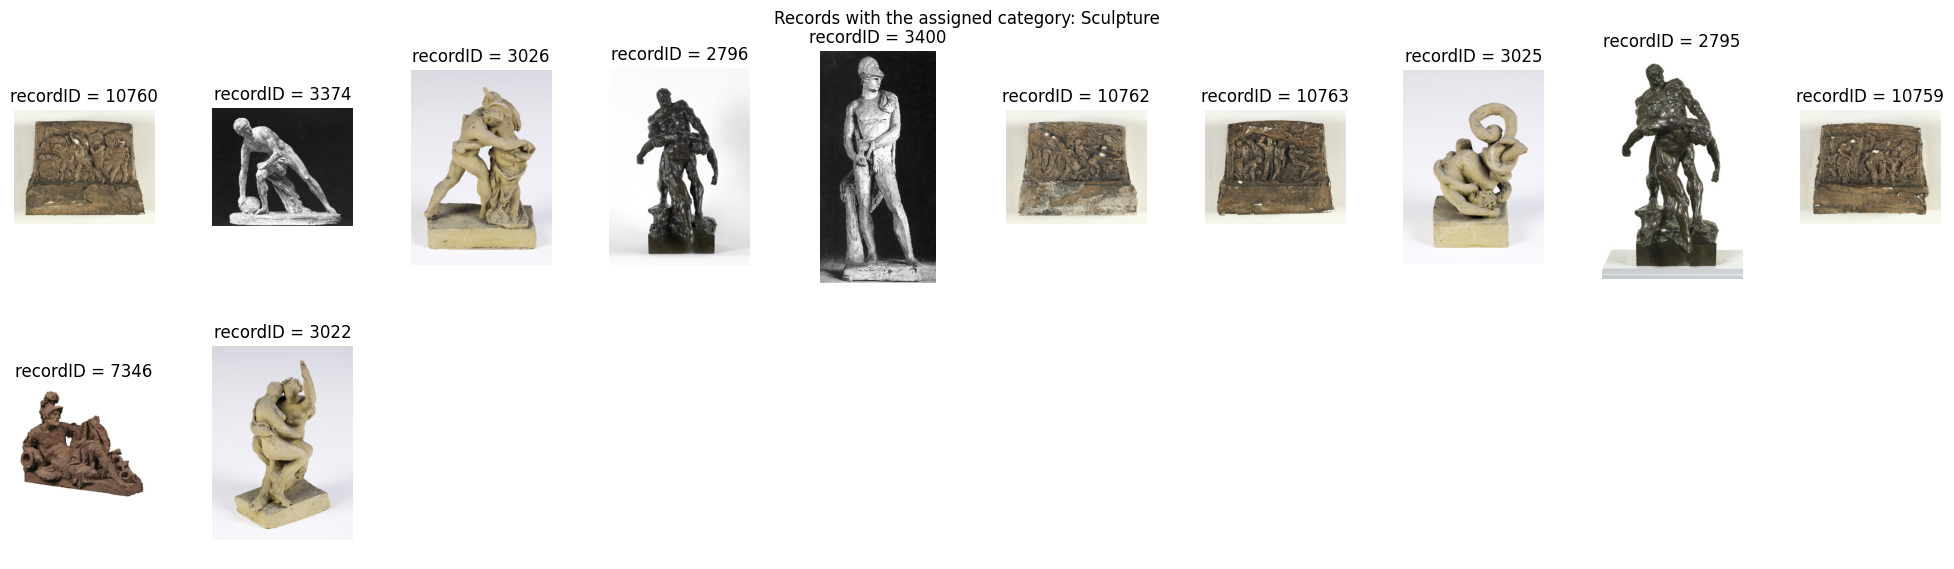

In [38]:
def show_N_by_N_with_category(W, H, category, seed=0):
    # Get the recordsIDS with the category
    recordIDs = record_to_category_table[record_to_category_table["category"] == category]["recordID"]
    recordIDs = list(recordIDs)
    random.seed(seed)
    random.shuffle(recordIDs)

    recordIDs = recordIDs[:min(W*H, len(recordIDs))]
    realH = np.ceil(len(recordIDs)/W).astype(int)

    fig, axs = plt.subplots(realH, W, figsize=(W*2, realH*3))
    fig.suptitle(f"Records with the assigned category: {category}")
    fig.tight_layout()


    for i in range(realH):
        for j in range(W):

            axs[i, j].axis("off")

            recordID_index = i * W + j
            if recordID_index >= len(recordIDs):
                continue
            
            recordID = recordIDs[recordID_index]
            path = filtered_data_downloaded[filtered_data_downloaded["recordID"] == recordID]["low_res_filename"].values[0]
            
            # Merge : IMAGES_FOLDER + path[1:]
            merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
            img = plt.imread(merged_path)

            axs[i, j].imshow(img, cmap="gray")
            axs[i, j].set_title(f"recordID = {recordID}")
    
    plt.savefig(os.path.join(FOLDER_FIGURES, f"Records_with_category_{category}.pdf"))
    plt.show()

for category in categories:
    show_N_by_N_with_category(10, 4, category)

In [39]:
def union(lst1, lst2):
    commons = []
    for item in lst2:
        if item in lst1:
            commons.append(item)
    return commons

# Get images per objectWorkType to generate the validation and the test sets

RATIO = 0.1 # 10% of the images will be used for validation and 10% for test
MIN_NUMBER_OF_IMAGES_PER_CATEGORY = 5

validation_set = pd.DataFrame(columns=["recordID", "category"])
testing_set = pd.DataFrame(columns=["recordID", "category"])

table_validation = pd.DataFrame(columns=["Category", "Number of images", "Proportion in validation set", "Proportion in full dataset"])
table_testing = pd.DataFrame(columns=["Category", "Number of images", "Proportion in testing set", "Proportion in full dataset"])

for index, category in enumerate(categories):
    
    proportion = category_to_count_table.iloc[index]["Number of assigned record"] / len(filtered_data_downloaded)

    number_of_images_for_validation = max(int(proportion * RATIO * N), MIN_NUMBER_OF_IMAGES_PER_CATEGORY)
    number_of_images_for_test = max(int(proportion * RATIO * N), MIN_NUMBER_OF_IMAGES_PER_CATEGORY)

    table_validation.loc[index] = [category, number_of_images_for_validation, None, "%.3f" % round(100*proportion, 3) + "%"]
    table_testing.loc[index] = [category, number_of_images_for_test, None, "%.3f" % round(100*proportion, 3) + "%"]

    recordIDs_for_category = record_to_category_table[record_to_category_table["category"] == category]["recordID"].to_list()
    assert len(recordIDs_for_category) >= (number_of_images_for_validation + number_of_images_for_test)

    # Get the validation set images
    random.seed(0)
    random.shuffle(recordIDs_for_category)
    for recordID in recordIDs_for_category[:number_of_images_for_validation]:
        validation_set.loc[len(validation_set)] = [recordID, category]

    # Remove the validation set images from the copy
    recordIDs_for_category = recordIDs_for_category[number_of_images_for_validation:]
    assert len(union(validation_set["recordID"].to_list(), recordIDs_for_category)) == 0

    # Get the test set images
    for recordID in recordIDs_for_category[:number_of_images_for_test]:
        testing_set.loc[len(testing_set)] = [recordID, category]

size_validation = len(validation_set)
size_testing = len(testing_set)

proportions_in_validation = table_validation["Number of images"] / size_validation
proportions_in_validation = ["%.3f" % round(proportion*100, 3) + "%" for proportion in proportions_in_validation]

proportions_in_testing = table_testing["Number of images"] / size_testing
proportions_in_testing = ["%.3f" % round(proportion*100, 3) + "%" for proportion in proportions_in_testing]

table_validation["Proportion in validation set"] = proportions_in_validation
table_testing["Proportion in testing set"] = proportions_in_testing

table_validation.to_csv(FOLDER_TABLE + "table_validation.csv", index=False)
table_testing.to_csv(FOLDER_TABLE + "table_testing.csv", index=False)

table_validation.loc[len(table_validation)] = ["All", size_validation, "100%", "100%"]
table_testing.loc[len(table_testing)] = ["All", size_testing, "100%", "100%"]

In [40]:
validation_set

recordID   category
0        1346    Tableau
1        4571    Tableau
2       10900    Tableau
3         579    Tableau
4        2316    Tableau
..        ...        ...
299     10760  Sculpture
300      3374  Sculpture
301      3026  Sculpture
302      2796  Sculpture
303      3400  Sculpture

[304 rows x 2 columns]

In [41]:
testing_set

recordID   category
0        8072    Tableau
1        1798    Tableau
2        1662    Tableau
3        8696    Tableau
4        4112    Tableau
..        ...        ...
299     10762  Sculpture
300     10763  Sculpture
301      3025  Sculpture
302      2795  Sculpture
303     10759  Sculpture

[304 rows x 2 columns]

In [42]:
union_recordIDs = union(validation_set["recordID"].to_list(), testing_set["recordID"].to_list())
assert len(union_recordIDs) == 0

In [43]:
table_validation

Category  Number of images Proportion in validation set  \
0    Tableau               198                      65.132%   
1     Dessin               101                      33.224%   
2  Sculpture                 5                       1.645%   
3        All               304                         100%   

  Proportion in full dataset  
0                    65.837%  
1                    33.765%  
2                     0.398%  
3                       100%

In [44]:
table_testing

Category  Number of images Proportion in testing set  \
0    Tableau               198                   65.132%   
1     Dessin               101                   33.224%   
2  Sculpture                 5                    1.645%   
3        All               304                      100%   

  Proportion in full dataset  
0                    65.837%  
1                    33.765%  
2                     0.398%  
3                       100%

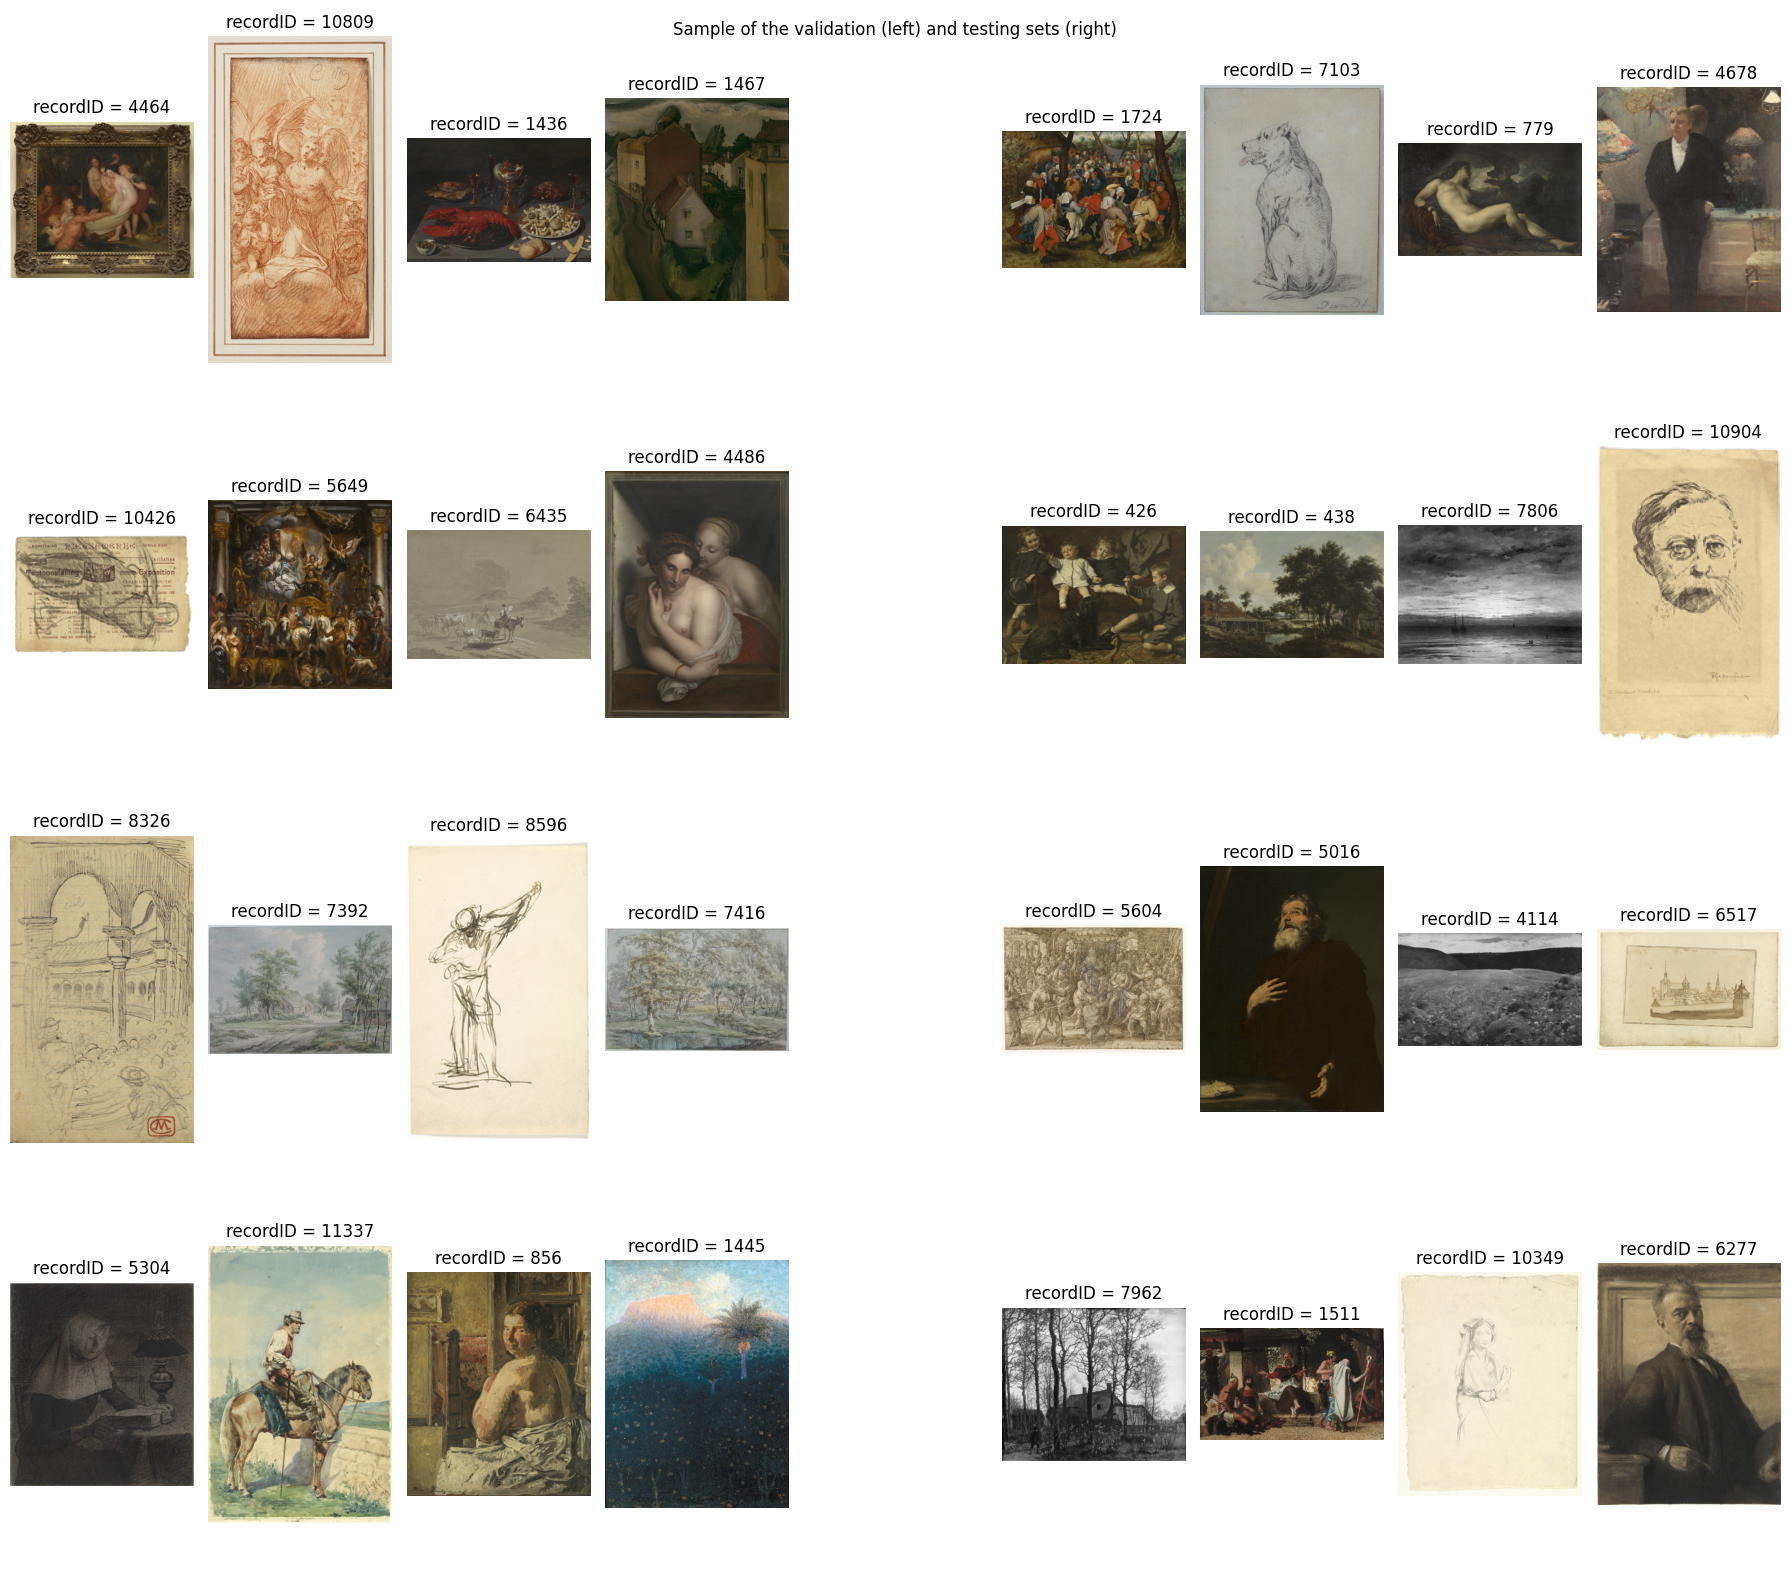

In [45]:
def display_sets(validation_set, testing_set, seed=0):
    # Two 4x4 grids, one for the validation set and one for the testing set 
    fig, axs = plt.subplots(4, 9, figsize=(9 * 2, 3 * 5 + 1))

    random.seed(seed)
    recordIDs_validation = random.sample(validation_set["recordID"].to_list(), 16)
    recordIDs_testing = random.sample(testing_set["recordID"].to_list(), 16)

    # Validation set (first 4x4 grid)
    for rowIndex in range(4):
        for colIndex in range(4):
            recordID = recordIDs_validation[rowIndex * 4 + colIndex]
            path = filtered_data_downloaded[filtered_data_downloaded["recordID"] == recordID]["low_res_filename"].values[0]
            merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
            img = plt.imread(merged_path)

            axs[rowIndex, colIndex].imshow(img, cmap="gray")
            axs[rowIndex, colIndex].axis("off")
            axs[rowIndex, colIndex].set_title(f"recordID = {recordID}")

    for i in range(4):
        axs[i, 4].axis("off")

    # Testing set (second 4x4 grid)
    for rowIndex in range(4):
        for colIndex in range(4):
            recordID = recordIDs_testing[rowIndex * 4 + colIndex]
            path = filtered_data_downloaded[filtered_data_downloaded["recordID"] == recordID]["low_res_filename"].values[0]
            merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
            img = plt.imread(merged_path)
            axs[rowIndex, colIndex + 5].imshow(img, cmap="gray")
            axs[rowIndex, colIndex + 5].axis("off")
            axs[rowIndex, colIndex + 5].set_title(f"recordID = {recordID}")

    plt.tight_layout()
    plt.suptitle("Sample of the validation (left) and testing sets (right)")
    plt.savefig(FOLDER_FIGURES + "validation_and_testing_sets.pdf")
    plt.show()

display_sets(validation_set, testing_set)

In [46]:
# Save the validation and testing sets
validation_set.to_csv(RECORD_IDS_VALIDATION_SET, index=False)
testing_set.to_csv(RECORD_IDS_TESTING_SET, index=False)